In [3]:
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
# Torch package
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [4]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Read Data

In [5]:
df = pd.read_csv('Processed_data_till_1_march.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Initial dataframe has few rows which has zeros for features like "SMA_7" etc and hence removing few top rows
df=df[50:]
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [6]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


## Normalize data

In [7]:
target_mean = df[target].mean()
target_stdev = df[target].std()

mean=dict()
stdev=dict()
for c in df.columns:
    mean[c] = df[c].mean()
    stdev[c] = df[c].std()

    df[c] = (df[c] - mean[c]) / stdev[c]

In [8]:
df.head()

,Close,Volume,EMA_7,EMA_14,EMA_21,SMA_7,SMA_14,SMA_21,MACD_12_26_9,MACDh_12_26_9,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
50,-2.216035,0.076483,-2.142262,-2.152261,-2.194267,-2.125236,-2.076858,-2.136731,0.580627,-0.832570,...,-0.051602,1.239983,0.263215,0.069296,-0.504898,-0.245371,0.621244,0.493902,0.076677,-2.216035
51,-2.056965,-0.239245,-2.123602,-2.142163,-2.184183,-2.111332,-2.077166,-2.125910,0.587184,-0.650028,...,-0.049936,0.645604,-1.592823,0.546749,0.078090,-0.237026,-0.837124,-0.175958,0.061469,-2.056965
52,-2.098709,-0.344334,-2.120115,-2.139050,-2.178879,-2.117365,-2.077906,-2.121902,0.551176,-0.605426,...,-0.049715,0.155241,0.435721,0.581028,6.329870,-1.246710,0.090208,-0.326489,0.989154,-2.098709
53,-2.101239,0.232217,-2.118136,-2.136693,-2.174291,-2.119588,-2.081983,-2.115752,0.513769,-0.573078,...,-0.049288,0.938548,0.039596,0.103050,0.078090,0.572390,-0.203051,-1.432887,0.008242,-2.101239
54,-2.114521,0.606201,-2.119995,-2.136444,-2.171350,-2.119997,-2.105306,-2.108239,0.467045,-0.569404,...,-0.048312,0.724147,0.148211,-0.139122,1.708155,0.405500,0.288356,0.019731,0.152717,-2.114521


## Data processing for time series model

The data processing is to prepare the data in a sequence of past observations. Preparation of the time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance and window decides how many days we want to predict for. If the sequence length is $n$ and window is $w$, then the LSTM considers the last $n$ observations to predict the next $w$ day price.

In [9]:
sequence_length = 60
window =6

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,2):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

In [10]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df))-6
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 3208
Train sample 3202
Test sample 6


In [11]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

X_train=torch.FloatTensor(np.array(X_train))
y_train=torch.FloatTensor(np.array(y_train))

print(X_train.shape, y_train.shape)

torch.Size([1568, 60, 29]) torch.Size([1568, 6])


In [12]:
batch_size=10
train_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
test_loader= DataLoader(data.TensorDataset(X_test, y_test), shuffle=True, batch_size=batch_size)

NameError: name 'X_test' is not defined

In [ ]:
# The unknown data
X_check=(df_train[features].values)[len(df_train)-sequence_length:len(df_train)]
y_check=(df_test[target].values)[:window]
torch.FloatTensor([X_check]).shape

## Classical LSTM

We first define train_model: function to train the model based on the batches of data
We print the loss at the end to understand how the model is performing with regards to the data.

In [13]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Classical LSTM

In [14]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1) # The output dimesion is set as window
        self.linear_2 = nn.Linear(in_features=60, out_features=6)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_l1, (hn, _) = self.lstm(x, (h0, c0))
        out_l2 = self.linear(out_l1)
        out = self.linear_2(torch.squeeze(out_l2))
        return torch.squeeze(out)

In [15]:
learning_rate = 0.001
num_hidden_units = 16

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [174]:
lstm_loss_train = []
num_epoch=10
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    y_test_pred_lstm = model_lstm(torch.FloatTensor([X_check]))
    y_test_pred_lstm = y_test_pred_lstm.detach().numpy()
    print(mean_absolute_error(y_check* target_stdev + target_mean,y_test_pred_lstm* target_stdev + target_mean))
    lstm_loss_train.append(train_loss)

Epoch 0
---------
Train loss: 0.3199307121763563
48.09751953124987
Epoch 1
---------
Train loss: 0.0817431479716187
30.25027018229154
Epoch 2
---------
Train loss: 0.05503996690604717
82.88826171874992
Epoch 3
---------
Train loss: 0.04411906815448385
78.53548502604174
Epoch 4
---------
Train loss: 0.039064267685838566
25.533287760416744
Epoch 5
---------
Train loss: 0.03355290644036926
51.8158463541666
Epoch 6
---------
Train loss: 0.032059798791269016
62.77596354166675
Epoch 7
---------
Train loss: 0.030445779347495667
74.62915364583341
Epoch 8
---------
Train loss: 0.02923964625402431
108.18302734375008
Epoch 9
---------
Train loss: 0.027694472443953063
95.58439453125008


In [175]:
lstm_loss_train

[0.3199307121763563,
 0.0817431479716187,
 0.05503996690604717,
 0.04411906815448385,
 0.039064267685838566,
 0.03355290644036926,
 0.032059798791269016,
 0.030445779347495667,
 0.02923964625402431,
 0.027694472443953063]

In [176]:
lstm_loss_test

[0.03372592618688941,
 0.03008799348026514,
 0.045939779840409756,
 0.06955239363014698,
 0.034197764936834574,
 0.05283508263528347,
 0.03963572718203068,
 0.03592234058305621,
 0.03374815289862454,
 0.06457534618675709]

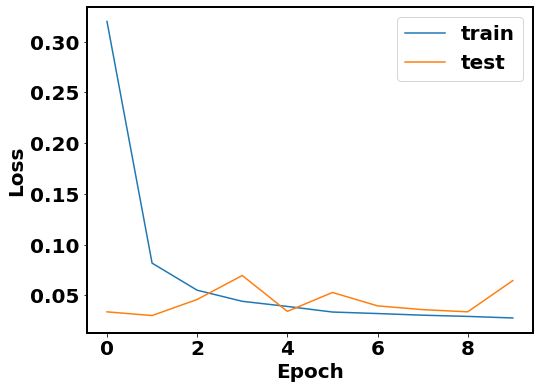

In [177]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), lstm_loss_train, label='train')
plt.plot(range(num_epoch), lstm_loss_test, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [178]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [179]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=batch_size)
y_train_pred_lstm=predict(train_eval_loader, model_lstm)
y_train_lstm=[]
for X, y in train_eval_loader:
    y_train_lstm.append(y)
    

In [180]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [181]:
mae_train_lstm, rmse_train_lstm= cal_metrics(y_train_lstm,y_train_pred_lstm)
print('MAE train error is',mae_train_lstm)
print('RMSE train error is',rmse_train_lstm)


MAE train error is 75.61781765397187
RMSE train error is 98.94566566321501


In [182]:
y_check_pred_lstm = model_lstm(torch.FloatTensor([X_check]))
y_check_pred_lstm = y_check_pred_lstm.detach().numpy()

mae_check_lstm = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean)
print('MAE check error  : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean, squared=False)
print('RMSE check error : ',rmse_check_lstm)

MAE check error  :  95.58439453125008
RMSE check error :  104.40334217618988


In [183]:
total_params_Q = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)

print("No. of parameters for QLSTM: ", total_params_Q)

No. of parameters for QLSTM:  5567


# Predict for 8th to 15 march

In [184]:
last_60 = pd.read_csv('last_60_days_input.csv')
last_60 = last_60.drop([ 'Unnamed: 0'], axis=1)
# Remove few redundant data
last_60=last_60.drop(columns=['Date'])
last_60=last_60.drop(columns=['CUMLOGRET_1'])
last_60=last_60.drop(columns=['Gold in USD volume'])
last_60=last_60.drop(columns=['Open'])
last_60=last_60.drop(columns=['High'])
last_60=last_60.drop(columns=['Low'])

In [185]:
for i in features:
    last_60[i]=(last_60[i]-mean[i])/stdev[i]

In [186]:
X_last_60=np.array(last_60[features])

In [190]:
y_8_to_15 = model_lstm(torch.FloatTensor([X_last_60]))
y_8_to_15 = y_8_to_15.detach().numpy()* target_stdev + target_mean

In [191]:
# Below is prediction for 8th, 11th,12th,13th,14th and 15 march
y_8_to_15

array([7613.735 , 7622.447 , 7597.5366, 7610.9326, 7623.293 , 7636.1094],
      dtype=float32)

In [16]:
total_params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)
print("No. of parameters for LSTM: ", total_params)

No. of parameters for LSTM:  5567
